# 7章 線形モデル上のバンディット 報酬が2値の場合

Author: hagino3000  
Date: 2016-11-30

「バンディット問題の理論とアルゴリズム」[1] の7章のアルゴリズムを実装して動かしてみる．  
報酬が二値のケース

- LinUCB
- 線形モデル上のトンプソン抽出
- ロジスティック回帰モデル上のトンプソン抽出


[1] 「バンディット問題の理論とアルゴリズム」本多淳也／中村篤祥・著 http://www.kspub.co.jp/book/detail/1529175.html

## 実験データ

報酬はネット広告のクリック = {0, 1} ，μは2%前後 とする  
デザインとフォントは時刻tのコンテキスト(オーディエンス属性)に依存する，コンテキスト付きバンディット問題

In [1]:
# 報酬は {0, 1}
# 真の報酬モデル
campaigns = {
    'campaign_a': 0.1,
    'campaign_b': 0.25,
    'campaign_c': 0.4,
    'campaign_d': 0.3,
    'campaign_e': 0.2,
    'campaign_f': 0.1
}
attribute = {
    'men_20':    -4,
    'men_30':    -3.8,
    'female_20': -4,
    'female_30': -3.8  
}
# デザインとfontはユーザー属性に依存して報酬が決まる
contextual_attrs = {
    'men_20': {
        'design': {
            'a': 0.2,
            'b':-0.1,
            'c': 0.1,
            'd': 0.01
        },
        'font': {'a': 0.1, 'b': 0.2}
    },
    'men_30': {
        'design': {
            'a': 0.3,
            'b':-0.1,
            'c': 0.15,
            'd': 0.01
        },
        'font': {'a': 0.1, 'b': -0.1}
    },
    'female_20': {
        'design': {
            'a':-0.10,
            'b': 0.20,  
            'c': 0.1,
            'd': 0.01
        },
        'font': {'a': 0.1,'b': -0.1}
    }, 
    'female_30': {
        'design': {
            'a':-0.1,
            'b': 0.2, 
            'c': 0.12,
            'd': 0.01
        },
        'font': {'a': -0.1, 'b': 0.1}
    }
}

contextual_columns = []
contextual_values = []
for attr, attr_v in contextual_attrs.items():
    for el, el_v in attr_v.items():
        for type_name, value in el_v.items():
            contextual_columns.append(attr + '_' + el + '_' + type_name)
            contextual_values.append(value)

actions = []
for a in [campaigns.keys(), attribute.keys(), contextual_columns]:
    actions.extend(a)
theta = []
for a in [campaigns.values(), attribute.values(), contextual_values]:
    theta.extend(a)
theta = np.array(theta)

In [2]:
# actionの要素
print(actions)

['campaign_e', 'campaign_d', 'campaign_a', 'campaign_c', 'campaign_b', 'campaign_f', 'men_20', 'female_30', 'men_30', 'female_20', 'men_20_font_b', 'men_20_font_a', 'men_20_design_b', 'men_20_design_d', 'men_20_design_a', 'men_20_design_c', 'female_30_font_b', 'female_30_font_a', 'female_30_design_b', 'female_30_design_d', 'female_30_design_a', 'female_30_design_c', 'men_30_font_b', 'men_30_font_a', 'men_30_design_b', 'men_30_design_d', 'men_30_design_a', 'men_30_design_c', 'female_20_font_b', 'female_20_font_a', 'female_20_design_b', 'female_20_design_d', 'female_20_design_a', 'female_20_design_c']


In [3]:
print(theta)

[ 0.2   0.3   0.1   0.4   0.25  0.1  -4.   -3.8  -3.8  -4.    0.2   0.1
 -0.1   0.01  0.2   0.1   0.1  -0.1   0.2   0.01 -0.1   0.12 -0.1   0.1
 -0.1   0.01  0.3   0.15 -0.1   0.1   0.2   0.01 -0.1   0.1 ]


In [4]:
empty_row = {}
for c in actions:
    empty_row[c] = 0

In [5]:
print(empty_row)

{'campaign_e': 0, 'men_30_design_a': 0, 'men_20_design_c': 0, 'campaign_a': 0, 'female_20_design_c': 0, 'female_20_design_b': 0, 'female_20_font_b': 0, 'female_20_design_a': 0, 'female_20_design_d': 0, 'men_20_design_a': 0, 'female_30_design_d': 0, 'female_30': 0, 'campaign_c': 0, 'campaign_b': 0, 'female_30_font_b': 0, 'men_20_font_b': 0, 'men_30_design_c': 0, 'men_20_font_a': 0, 'female_30_design_c': 0, 'campaign_d': 0, 'men_30_font_b': 0, 'female_30_design_a': 0, 'female_30_font_a': 0, 'female_20': 0, 'men_20_design_b': 0, 'female_30_design_b': 0, 'men_30_font_a': 0, 'female_20_font_a': 0, 'men_20': 0, 'men_30_design_d': 0, 'men_20_design_d': 0, 'men_30': 0, 'campaign_f': 0, 'men_30_design_b': 0}


In [6]:
ret = []
for k, v in campaigns.items():
    cp = k
    cp_value = v
    for k, v in attribute.items():
        attr = k
        attr_value = v
        for k, v in contextual_attrs[attr]['design'].items():
            design = k
            design_value = v
            for k, v in contextual_attrs[attr]['font'].items():
                font = k
                font_value = v
                row = empty_row.copy()
                row[cp] = 1
                row[attr] = 1
                row[attr + '_design_' + design] = 1
                row[attr + '_font_' + font] = 1
                ret.append(row)

## 選択可能なactionの組み合わせ

In [7]:
df_actions = pd.DataFrame.from_dict(ret)
df_actions = df_actions[actions]
df_actions

,campaign_e,campaign_d,campaign_a,campaign_c,campaign_b,campaign_f,men_20,female_30,men_30,female_20,...,men_30_design_b,men_30_design_d,men_30_design_a,men_30_design_c,female_20_font_b,female_20_font_a,female_20_design_b,female_20_design_d,female_20_design_a,female_20_design_c
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# コンテキストの生成
contexts = [k for k in attribute.keys()]
def get_context(t):
    return contexts[t % len(contexts)]

In [9]:
# 0 or 1 の報酬を返す関数
def calc_reward_proba(action):
    exp_theta_T_action = np.exp(theta.dot(action))
    probability = exp_theta_T_action/(1 + exp_theta_T_action)
    return probability

def get_reward(action):
    return np.random.binomial(1, calc_reward_proba(action), 1)[0]

In [10]:
for i in range(22):
    print('CTR for action', i ,'=', calc_reward_proba(df_actions.iloc[i].values))

CTR for action 0 = 0.0241270214177
CTR for action 1 = 0.0218812709361
CTR for action 2 = 0.0268571187848
CTR for action 3 = 0.0243635943153
CTR for action 4 = 0.0322954646985
CTR for action 5 = 0.0293122307514
CTR for action 6 = 0.0293122307514
CTR for action 7 = 0.0265969935769
CTR for action 8 = 0.0355711892726
CTR for action 9 = 0.0293122307514
CTR for action 10 = 0.0295981041791
CTR for action 11 = 0.0243635943153
CTR for action 12 = 0.0265969935769
CTR for action 13 = 0.0218812709361
CTR for action 14 = 0.0329263947981
CTR for action 15 = 0.0271197172018
CTR for action 16 = 0.0218812709361
CTR for action 17 = 0.0265969935769
CTR for action 18 = 0.0243635943153
CTR for action 19 = 0.0295981041791
CTR for action 20 = 0.0322954646985
CTR for action 21 = 0.0391657227968


## LinUCB

118頁，アルゴリズム7.1

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2, \alpha > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\hat{\theta} \leftarrow A^{-1}b. \\
\hspace{10pt}//\ 各行動iについてUCBスコアの計算，ただし \alpha_t = \alpha\sqrt{logt} \\
\hspace{10pt}\overline{\mu_i} = a_{i,t}^{\mathrm{T}}\hat{\theta} + \alpha_t\sigma\sqrt{a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}\\
\hspace{10pt}スコア最大の行動\ i\ \leftarrow\ argmax_i\overline{\mu_i}_(t) を選択して報酬 X(t) を観測 \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [11]:
def calc_new_a_inv(A_inv, a_i_t):
    return A_inv - (A_inv*(np.matrix(a_i_t).T)*(a_i_t)*A_inv)/(1 + a_i_t.dot(A_inv).dot(a_i_t))

In [12]:
def linucb(T=1000, input_sigma2=600, param_sigma02=0.01, param_alpha=10):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))    

    # results
    rewards = []
    for t in range(1, T):
        alpha_t = param_alpha*np.sqrt(np.log(t))
        theta_hat = A_inv.A.dot(b)
        context = get_context(t)
        ucb_scores = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            ucb_score = a_i.dot(theta_hat) + alpha_t*np.sqrt(input_sigma2)*np.sqrt(a_i.dot(A_inv).dot(a_i))
            selectable_actions.append(a_i)
            ucb_scores.append(ucb_score)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(ucb_scores).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [13]:
def run_linucb_test(T, trial, param_sigma02=0.0001, param_alpha=10, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = linucb(T=T, param_sigma02=param_sigma02, param_alpha=param_alpha)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

Theta - ThetaHat:-12.940000933321034


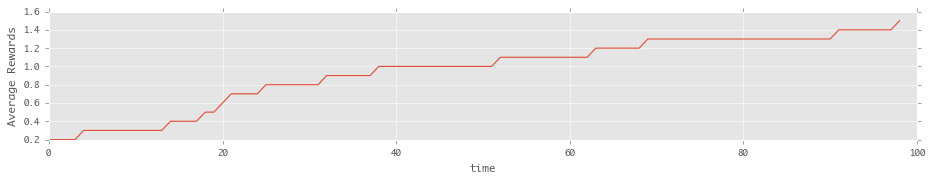

In [14]:
rewards = run_linucb_test(T=100, trial=10)

## パラメータチューニング

In [15]:
T = 1500
rewards_1 = run_linucb_test(T=T, trial=5, param_alpha=0.5, plot=False)
rewards_2 = run_linucb_test(T=T, trial=5, param_alpha=1, plot=False)
rewards_3 = run_linucb_test(T=T, trial=5, param_alpha=10, plot=False)
rewards_4 = run_linucb_test(T=T, trial=5, param_alpha=50, plot=False)

Theta - ThetaHat:-12.940029188144218
Theta - ThetaHat:-12.940029188705498
Theta - ThetaHat:-12.940027729077604
Theta - ThetaHat:-12.940027995763927


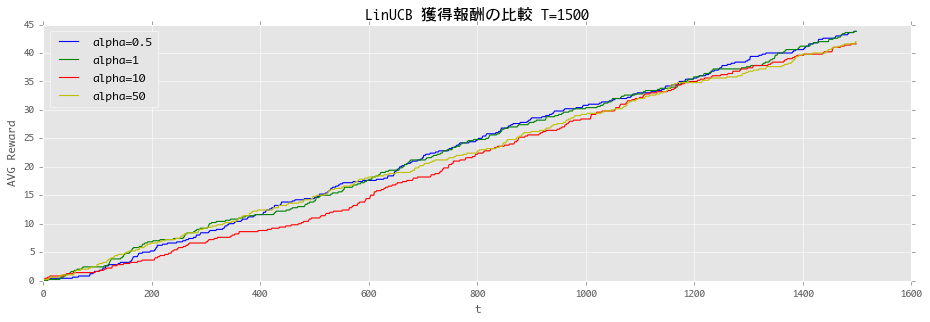

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='alpha=0.5')
plt.plot(rewards_2, color='g', label='alpha=1')
plt.plot(rewards_3, color='r', label='alpha=10')
plt.plot(rewards_4, color='y', label='alpha=50')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'LinUCB 獲得報酬の比較 T={}'.format(T))

# 正規分布モデルのThompson抽出

121頁, アルゴリズム7.2

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2 > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\tilde{\theta}\ を多変量正規分布\ N(A^{-1}b, \sigma^2A^{-1})\ から生成. \\
\hspace{10pt}i \leftarrow argmax_i\tilde{\theta}^{\mathrm{T}}_a{i,t} を選択して報酬 X(t) を観測. \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [17]:
def thompson_sampling(T=1000, input_sigma2=0.0001, param_sigma02=0.0001):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))

    # results
    rewards = []
    for t in range(1, T):
        theta_hat = np.random.multivariate_normal(A_inv.A.dot(b), input_sigma2*A_inv)
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = a_i.T.dot(theta_hat)
            selectable_actions.append(a_i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(estimated_rewards).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [18]:
def run_thompson_test(T, trial, param_sigma02=0.0002, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = thompson_sampling(T=T, param_sigma02=param_sigma02)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

In [19]:
# T=50でテスト
theta_hat, rewards, b = thompson_sampling(50)

In [20]:
# 全ての項から報酬が発生している (選択した) 事を確認
b

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [21]:
# t=50時点での\theta_hat
theta_hat

array([ -1.11928297e-02,  -1.77892210e-03,  -2.14037646e-03,
        -6.11712082e-04,  -6.87450085e-03,  -5.60347365e-05,
         1.69322129e-02,   1.81993519e-02,   5.72347531e-03,
         6.92431434e-03,  -8.20865242e-05,   5.11289416e-05,
        -2.56771664e-02,  -6.39318767e-03,  -1.58180877e-02,
        -2.18094271e-03,  -1.30384186e-02,  -1.26637600e-02,
        -6.88009762e-03,  -2.78735671e-03,  -5.32144574e-03,
        -1.07322016e-02,   4.71536553e-04,  -3.75928989e-03,
         4.77155708e-04,   2.80381836e-03,  -2.69030179e-03,
        -1.11309979e-03,   4.98324918e-03,  -1.75372965e-04,
        -8.96714512e-03,  -1.24796596e-02,  -4.88911282e-03,
         3.89463886e-03])

Theta - ThetaHat:-12.914555355771643


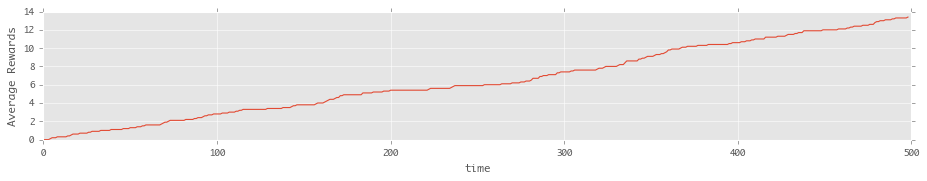

In [22]:
rewards_result = run_thompson_test(T=500, trial=10)

## パラメータチューニング

In [23]:
T = 1500
rewards_1 = run_thompson_test(T=T, trial=10, param_sigma02=0.00001, plot=False)
rewards_2 = run_thompson_test(T=T, trial=10, param_sigma02=0.0001, plot=False)
rewards_3 = run_thompson_test(T=T, trial=10, param_sigma02=0.001, plot=False)
rewards_4 = run_thompson_test(T=T, trial=10, param_sigma02=0.01, plot=False)

Theta - ThetaHat:-12.954196151371482
Theta - ThetaHat:-12.935081957413228
Theta - ThetaHat:-12.89747114393224
Theta - ThetaHat:-12.80601003976167


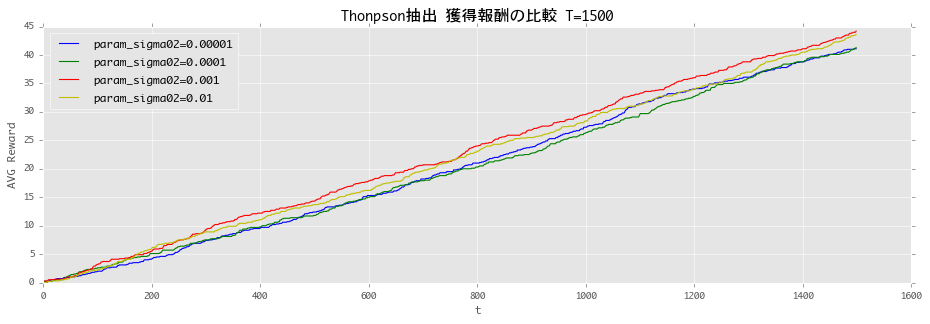

In [24]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='param_sigma02=0.00001')
plt.plot(rewards_2, color='g', label='param_sigma02=0.0001')
plt.plot(rewards_3, color='r', label='param_sigma02=0.001')
plt.plot(rewards_4, color='y', label='param_sigma02=0.01')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'Thonpson抽出 獲得報酬の比較 T={}'.format(T))

## 比較用のepsilon greedy実装

In [25]:
def epsilon_greedy(T=1000, epsilon=0.1):
    # results
    rewards = []
    selected_counts = np.zeros(len(df_actions))
    gained_rewards = np.zeros(len(df_actions))
    for t in range(1, T):
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_actions_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = gained_rewards[i]/selected_counts[i]
            selectable_actions.append(a_i)
            selectable_actions_idx.append(i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        if np.random.rand() > epsilon:
            _idx = np.array(estimated_rewards).argmax()
        else:
            # 探索
            _idx = np.random.randint(len(selectable_actions))
        a_i_t = selectable_actions[_idx]
        action_idx = selectable_actions_idx[_idx]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        rewards.append(reward)
        selected_counts[action_idx] += 1
        gained_rewards[action_idx] += reward

    return np.array(rewards), selected_counts

In [26]:
def run_epsilon_greedy_test(T, trial, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        rewards, selected_counts = epsilon_greedy(T=T)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

/Users/tnishibayashi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


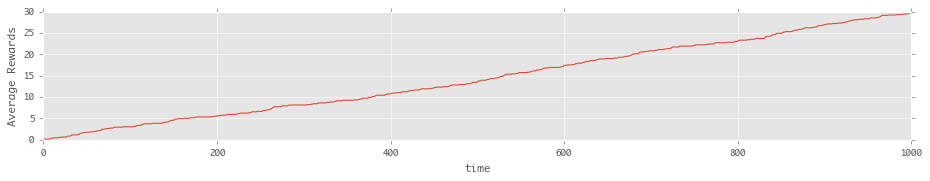

In [27]:
_, selected_count = run_epsilon_greedy_test(1000, trial=10, plot=True)

In [28]:
selected_count

array([ 72.6,  10.4,   2.3,   1.9,   1.6,   1.7,   1.5,   1.3,  19.2,
         1.8,   1.9,   1.6,   1.5,   1.2,   1.4,   7.1,  17. ,   8.6,
         1.8,   1.5,   4.1,  12.3,   1.6,   1.3,   4.6,   1.5,   1.5,
         4.6,   1.5,   1.8,   1.4,   7.2,   1.3,   1.4,   3.5,   1.7,
        13.7,   1.5,   5.3,   3.5,  19.6,   1.7,   4.4,   4.7,   2. ,
         1.5,   1.3,   1.4,  23. ,  19.7,   1.7,   1.9,   1.4,   1.6,
         9.2,   1.3,   1.2,  24. ,   1.3,  15.7,   1.4,  24.5,   1.3,
         1.8,   4.4,   1.5,   1.5,   1.3,   1.5,   1.3,   1.3,   5.3,
         1.1,   1.6,   1.4,   1.5,  14.8,   1.8,  17. ,   1.3,   1.4,
         1.1,  19.5,  15.9,   1.7,   1.2,   1.3,   1.3,   1.9,   7.9,
         1.6,   1.5,   1.5,   1.2,   1.4,   1.6,   4.1,   1.3,   5.9,
         1.8,   1.5,  10.4,   1.6,   1.6,  24.1,  11.7,   1.4,   7.2,
         1.3,   3.6,   3. ,   1.6,   1.7,   1.5,   6.1,   2.9,  21.4,
         1.3,   1.1,   1.7,   1.4,   1.7,   1.7,   1.6,   1.5,   1.3,
         1.8,  23.4,

## ロジスティック回帰モデル上のトンプソン抽出

125頁，アルゴリズム7.3

In [29]:
def calc_gradient(theta, var, action_history):
    ret = []
    ret.append(theta/var)

    for action_i_s, reward in action_history:
        exp_theta_T_action_i_s = np.exp(theta.dot(action_i_s))
        ret.append((exp_theta_T_action_i_s*action_i_s)/(1 + exp_theta_T_action_i_s))

    for action_i_s, reward in action_history:
        if reward == 1:
            ret.append(action_i_s * -1)
    return np.array(ret).sum(axis=0)

In [30]:
def calc_hessian(theta, var, action_history):
    ret = []
    ret.append(np.identity(len(actions))/var)

    for action_i_s, reward in action_history:
        exp_theta_T_action_i_s = np.exp(theta.dot(action_i_s))
        ret.append((exp_theta_T_action_i_s*(np.matrix(action_i_s).T)*action_i_s)/(1+exp_theta_T_action_i_s)**2)

    return np.array(ret).sum(axis=0)

In [31]:
def calc_theta_hat(theta_hat, var, action_history, traial=20):
    _theta_hat = theta_hat
    for _ in range(traial):
        hessian = calc_hessian(_theta_hat, 2, action_history)
        gradient = calc_gradient(_theta_hat, 2, action_history)
        _theta_hat = _theta_hat - np.linalg.inv(hessian).dot(gradient)
    return _theta_hat

In [32]:
def thompson_sampling_on_logistic_regression(T=1000, param_sigma02=0.01):
    rewards = []
    action_history = []
    selected_counts = np.zeros(len(df_actions))
    theta_hat = np.zeros(len(actions))
    for t in range(1, T):
        if t % 20 == 1:
            # 20回に1度だけtheta_hatを更新
            # 毎回初期状態から計算しているので遅い……
            # TODO 勾配ベクトルとヘッセ行列は前回の計算過程を使い回す
            theta_hat = calc_theta_hat(theta_hat, param_sigma02, action_history)
            hessian = calc_hessian(theta_hat, param_sigma02, action_history)
            hessian_inv = np.linalg.inv(hessian)

        theta_tild = np.random.multivariate_normal(
            theta_hat,
            hessian_inv
        )
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_action_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            selectable_actions.append(a_i)
            selectable_action_idx.append(i)
            estimated_rewards.append(a_i.T.dot(theta_tild))
        # 時刻tにおける行動 a_{i,t}
        argmax_i = np.array(estimated_rewards).argmax()
        a_i_t = selectable_actions[argmax_i]
        selected_i = selectable_action_idx[argmax_i]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        action_history.append((a_i_t, reward))
        rewards.append(reward)
        selected_counts[selected_i] += 1
    return theta_hat, np.array(rewards), selected_counts

In [33]:
def run_thompson_sampling_on_logistic_regression_test(T, trial, param_sigma02=0.01, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        theta_hat, rewards, selected_counts = thompson_sampling_on_logistic_regression(
            T=T,
            param_sigma02=param_sigma02)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

In [34]:
rewards_1, selected_count = run_thompson_sampling_on_logistic_regression_test(2000, 10, param_sigma02=0.00001, plot=False)
rewards_2, selected_count = run_thompson_sampling_on_logistic_regression_test(2000, 10, param_sigma02=0.0001, plot=False)
rewards_3, selected_count = run_thompson_sampling_on_logistic_regression_test(2000, 10, param_sigma02=0.001, plot=False)
rewards_4, selected_count = run_thompson_sampling_on_logistic_regression_test(2000, 10, param_sigma02=0.01, plot=False)

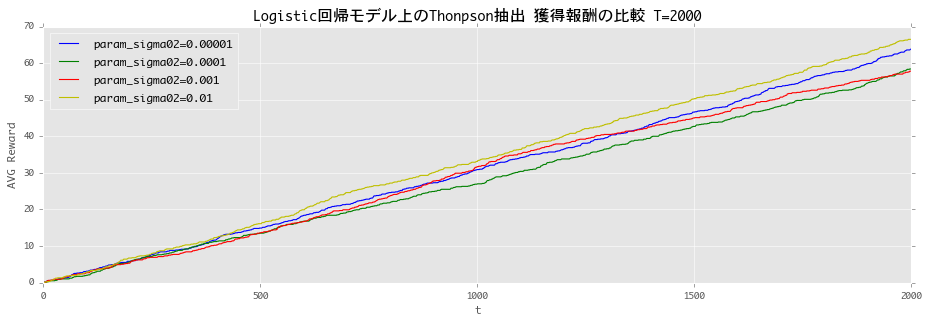

In [35]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='param_sigma02=0.00001')
plt.plot(rewards_2, color='g', label='param_sigma02=0.0001')
plt.plot(rewards_3, color='r', label='param_sigma02=0.001')
plt.plot(rewards_4, color='y', label='param_sigma02=0.01')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'Logistic回帰モデル上のThonpson抽出 獲得報酬の比較 T=2000')

## 比較

In [37]:
T=5000
trial=10
result_ep, selected_ep = run_epsilon_greedy_test(
    T=T, trial=trial, plot=False)

/Users/tnishibayashi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


In [38]:
result_ucb = run_linucb_test(
    T=T, trial=trial, param_alpha=1, plot=False)

Theta - ThetaHat:-12.940091487088731


In [39]:
result_thompson = run_thompson_test(
    T=T, trial=trial, param_sigma02=0.001, plot=False)

Theta - ThetaHat:-12.854085700454869


In [40]:
result_logistic_thompson = run_thompson_sampling_on_logistic_regression_test(
    T=T, trial=trial, param_sigma02=0.1, plot=False)

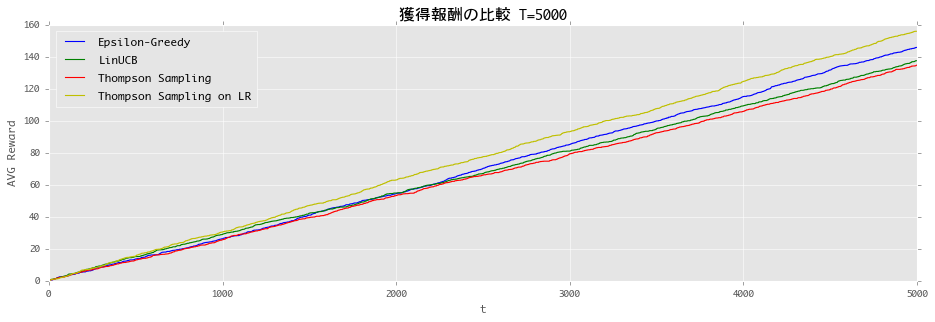

In [44]:
plt.figure(figsize=(14, 4))
plt.plot(result_ep, color='b', label='Epsilon-Greedy')
plt.plot(result_ucb, color='g', label='LinUCB')
plt.plot(result_thompson, color='r', label='Thompson Sampling')
plt.plot(result_logistic_thompson[0], color='y', label='Thompson Sampling on LR')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'獲得報酬の比較 T={}'.format(T))

ロジスティック回帰モデルのThompson抽出が一番良くなった